In [2]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from google.colab.patches import cv2_imshow

In [1]:
!pip install opencv-contrib-python-headless


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_image(path):
    image = cv2.imread(path)
    return image

def resize_image(image, width):
    aspect_ratio = width / image.shape[1]
    dim = (width, int(image.shape[0] * aspect_ratio))
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

def detect_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

def match_features(descriptors1, descriptors2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches[:15]  # Limit to top 50 matches

def find_homography(kp1, kp2, matches):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0)
    matchesMask = mask.ravel().tolist()
    return M, matchesMask

def align_images(image1, image2, M):
    h, w = image1.shape[:2]
    aligned_image2 = cv2.warpPerspective(image2, M, (w, h))
    return aligned_image2

def compute_ssim(image1, image2):
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    score, diff = ssim(gray_image1, gray_image2, full=True)
    return score

def verify_images(image1_path, image2_path):
    image1 = load_image(image1_path)
    image2 = load_image(image2_path)

    if image1 is None or image2 is None:
        print("One of the images could not be loaded.")
        return False

    # Resize images to a smaller width for faster processing
    image1 = resize_image(image1, 224)
    image2 = resize_image(image2, 224)

    kp1, des1 = detect_features(image1)
    kp2, des2 = detect_features(image2)

    matches = match_features(des1, des2)

    if len(matches) > 5:
        M, matchesMask = find_homography(kp1, kp2, matches)
        if M is not None:
            aligned_image2 = align_images(image1, image2, M)

            # Compute SSIM
            ssim_score = compute_ssim(image1, aligned_image2)
            print(f"SSIM Score: {ssim_score}")

            # Display the aligned images for visual verification
            cv2_imshow(image1)
            cv2_imshow(aligned_image2)

            # Consider images to be of the same area if SSIM score is high enough
            if ssim_score > 0.5:  # Threshold can be adjusted based on requirements
                return True
            else:
                return False
        else:
            print("Not enough matches to find homography.")
            return False
    else:
        print("Not enough matches found.")
        return False

SSIM Score: 0.05811905247866838


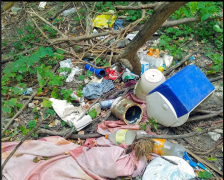

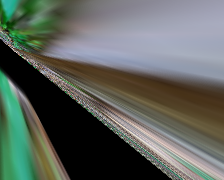

The images are not of the same area.


In [7]:
# Paths to the images
image1_path = '/content/23.png'
image2_path = '/content/24.png'

# Verify if the images are of the same area
same_area = verify_images(image1_path, image2_path)
if same_area:
    print("The images are of the same area.")
else:
    print("The images are not of the same area.")

In [8]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.9/78.2 GB disk)



WARNING ⚠️ NMS time limit 0.550s exceeded
0: 320x320 1 garbage, 12.4ms
Speed: 5.2ms preprocess, 12.4ms inference, 1119.9ms postprocess per image at shape (1, 3, 320, 320)


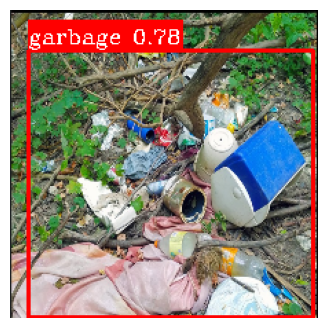

In [10]:
import torch
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the model
model_path = "/content/drive/MyDrive/yolo/train2/weights/best.pt"
model = YOLO(model_path)

# Load the image
image_path = "/content/23.png"
image = cv2.imread(image_path)

# Resize the image to 224x244
image_resized = cv2.resize(image, (224, 224))

# Convert BGR image to RGB
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

# Make predictions
results = model(image_rgb)

# Display the results
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes
    confs = result.boxes.conf.cpu().numpy()  # Confidence scores
    classes = result.boxes.cls.cpu().numpy()  # Class labels

    for box, conf, cls in zip(boxes, confs, classes):
        x1, y1, x2, y2 = map(int, box)
        label = f"{model.names[int(cls)]} {conf:.2f}"

        # Draw bounding box
        cv2.rectangle(image_resized, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color in BGR

        # Draw label with confidence score
        font = cv2.FONT_HERSHEY_COMPLEX
        font_scale = 0.5
        font_thickness = 1
        text_color = (255, 255, 255)  # White color in BGR
        text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
        text_w, text_h = text_size

        # Background rectangle for text
        cv2.rectangle(image_resized, (x1, y1 - text_h - 10), (x1 + text_w, y1), (0, 0, 255), -1)  # Red color background

        # Draw text on top of the background rectangle
        cv2.putText(image_resized, label, (x1, y1 - 5), font, font_scale, text_color, font_thickness)

# Convert the image back to RGB for display
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(4,4))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


**compiling background checking and model image prediction**

In [11]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch

In [15]:
# Load YOLO model
model_path = "/content/drive/MyDrive/yolo/train2/weights/best.pt"
model = YOLO(model_path)

# Function to load image
def load_image(path):
    image = cv2.imread(path)
    return image

# Function to resize image
def resize_image(image, width):
    aspect_ratio = width / image.shape[1]
    dim = (width, int(image.shape[0] * aspect_ratio))
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

# Function to detect features using SIFT
def detect_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

# Function to match features between two sets of descriptors
def match_features(descriptors1, descriptors2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches[:15]  # Limit to top 15 matches

# Function to find homography matrix
def find_homography(kp1, kp2, matches):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0)
    matchesMask = mask.ravel().tolist()
    return M, matchesMask

# Function to align images
def align_images(image1, image2, M):
    h, w = image1.shape[:2]
    aligned_image2 = cv2.warpPerspective(image2, M, (w, h))
    return aligned_image2

# Function to compute SSIM between two images
def compute_ssim(image1, image2):
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    score, diff = ssim(gray_image1, gray_image2, full=True)
    return score

# Function to verify if images are of the same area
def verify_images(image1_path, image2_path):
    image1 = load_image(image1_path)
    image2 = load_image(image2_path)

    if image1 is None or image2 is None:
        print("One of the images could not be loaded.")
        return False

    # Resize images to a smaller width for faster processing
    image1 = resize_image(image1, 224)
    image2 = resize_image(image2, 224)

    kp1, des1 = detect_features(image1)
    kp2, des2 = detect_features(image2)

    matches = match_features(des1, des2)

    if len(matches) > 5:
        M, matchesMask = find_homography(kp1, kp2, matches)
        if M is not None:
            aligned_image2 = align_images(image1, image2, M)

            # Compute SSIM
            ssim_score = compute_ssim(image1, aligned_image2)
            print(f"SSIM Score: {ssim_score}")

            # Display the aligned images for visual verification
            cv2_imshow(image1)
            cv2_imshow(aligned_image2)

            # Consider images to be of the same area if SSIM score is high enough
            if ssim_score > 0.055:  # Threshold can be adjusted based on requirements
                return True
            else:
                return False
        else:
            print("Not enough matches to find homography.")
            return False
    else:
        print("Not enough matches found.")
        return False


In [16]:
# Function to make predictions using YOLO model
def make_predictions(image):
    # Resize the image to 224x224
    image_resized = cv2.resize(image, (224, 224))

    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

    # Make predictions
    results = model(image_rgb)

    return results, image_resized

# Function to draw predictions on image
def draw_predictions(image, results):
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes
        confs = result.boxes.conf.cpu().numpy()  # Confidence scores
        classes = result.boxes.cls.cpu().numpy()  # Class labels

        for box, conf, cls in zip(boxes, confs, classes):
            x1, y1, x2, y2 = map(int, box)
            label = f"{model.names[int(cls)]} {conf:.2f}"

            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color in BGR

            # Draw label with confidence score
            font = cv2.FONT_HERSHEY_COMPLEX
            font_scale = 0.5
            font_thickness = 1
            text_color = (255, 255, 255)  # White color in BGR
            text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
            text_w, text_h = text_size

            # Background rectangle for text
            cv2.rectangle(image, (x1, y1 - text_h - 10), (x1 + text_w, y1), (0, 0, 255), -1)  # Red color background

            # Draw text on top of the background rectangle
            cv2.putText(image, label, (x1, y1 - 5), font, font_scale, text_color, font_thickness)

    # Convert the image back to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image_rgb


0: 320x320 1 garbage, 8.7ms
Speed: 1.4ms preprocess, 8.7ms inference, 3.6ms postprocess per image at shape (1, 3, 320, 320)


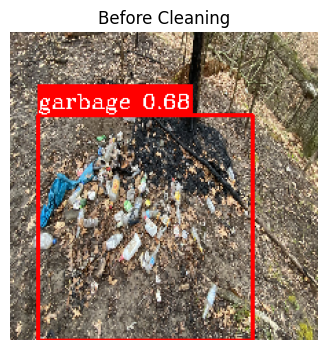


0: 320x320 (no detections), 15.8ms
Speed: 1.3ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)


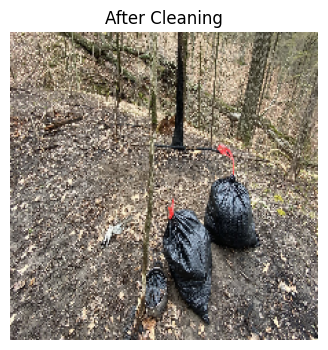

SSIM Score: 0.06254517869381902


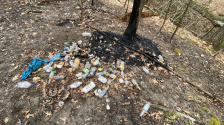

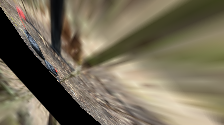

The images are of the same area.
Comparison Report:
Garbage detected in the first image: Yes
Confidence scores in the first image: [0.68017995]
Garbage detected in the second image: No
Confidence scores in the second image: []
Garbage has been cleaned.



In [22]:
# Paths to the images
image1_path = '/content/with garbage.jpg'
image2_path = '/content/withoutgarbage.jpg'

# Load and make predictions on the first image
image1 = load_image(image1_path)
results1, image1_resized = make_predictions(image1)
image1_with_predictions = draw_predictions(image1_resized, results1)

# Display the first image with predictions
plt.figure(figsize=(4, 4))
plt.imshow(image1_with_predictions)
plt.axis('off')
plt.title('Before Cleaning')
plt.show()

# Load and make predictions on the second image
image2 = load_image(image2_path)
results2, image2_resized = make_predictions(image2)
image2_with_predictions = draw_predictions(image2_resized, results2)

# Display the second image with predictions
plt.figure(figsize=(4, 4))
plt.imshow(image2_with_predictions)
plt.axis('off')
plt.title('After Cleaning')
plt.show()

# Verify if the images are of the same area
same_area = verify_images(image1_path, image2_path)
if same_area:
    print("The images are of the same area.")
else:
    print("The images are not of the same area.")

# Generate comparison report
def generate_comparison_report(results1, results2, confidence_threshold=0.5):
    def is_garbage_detected(results, threshold):
        confidence_scores = []
        for result in results:
            confs = result.boxes.conf.cpu().numpy()  # Confidence scores
            classes = result.boxes.cls.cpu().numpy()  # Class labels
            for conf, cls in zip(confs, classes):
                if cls == 0:  # Assuming garbage class is 0
                    confidence_scores.append(conf)
                    if conf >= threshold:
                        return True, confidence_scores
        return False, confidence_scores

    garbage_before, confs_before = is_garbage_detected(results1, confidence_threshold)
    garbage_after, confs_after = is_garbage_detected(results2, confidence_threshold)

    report = "Comparison Report:\n"
    report += f"Garbage detected in the first image: {'Yes' if garbage_before else 'No'}\n"
    report += f"Confidence scores in the first image: {confs_before}\n"
    report += f"Garbage detected in the second image: {'Yes' if garbage_after else 'No'}\n"
    report += f"Confidence scores in the second image: {confs_after}\n"

    if not garbage_before and not garbage_after:
        report += "No garbage detected in both images.\n"
    elif garbage_before and not garbage_after:
        report += "Garbage has been cleaned.\n"
    elif not garbage_before and garbage_after:
        report += "New garbage detected after cleaning.\n"
    else:
        report += "Garbage is present in both images.\n"

    return report


# Generate and print the comparison report with a confidence threshold of 0.5
report = generate_comparison_report(results1, results2, confidence_threshold=0.5)
print(report)